
--- This is a regression problem ---

1. Loading dataset from file...

2. Calculating gram matrices. This could take a while...
--- shortest path kernel matrix of size 183 built in 12.671883821487427 seconds ---

gram matrix with parameters {} is: 
[[ 3.  1.  3. ...  1.  1.  1.]
 [ 1.  6.  1. ...  0.  0.  3.]
 [ 3.  1.  3. ...  1.  1.  1.]
 ...
 [ 1.  0.  1. ... 55. 21.  7.]
 [ 1.  0.  1. ... 21. 55.  7.]
 [ 1.  3.  1. ...  7.  7. 55.]]


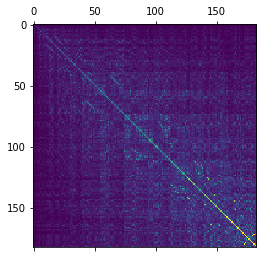


3. Fitting and predicting using nested cross validation. This could really take a while...
calculate performance:   0%|          | 1/630 [00:00<01:12,  8.66it/s]

/home/ljia/.local/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


                                                                        
4. Getting final performances...

best_params_out:  [{}]
best_params_in:  [{'alpha': 35.481338923357534}]
best_val_perf:  36.08752278925261
best_val_std:  0.9660235949265693
final_performance:  36.45033825376652
final_confidence:  6.625276016213645
train_performance:  28.645168242623424
train_std:  0.59327479451686
time to calculate gram matrix:  12.671883821487427 s

params                 train_perf      valid_perf       test_perf          gram_matrix_time
---------------------  --------------  ---------------  ---------------  ------------------
{'alpha': '1.00e-01'}  463.68±735.85   1255.03±1875.15  1552.81±4500.30               12.67
{'alpha': '1.41e-01'}  371.29±454.77   910.40±924.50    893.80±1213.60                12.67
{'alpha': '2.00e-01'}  522.21±1406.90  1587.46±4629.03  1301.10±3657.93               12.67
{'alpha': '2.82e-01'}  248.98±245.92   721.57±817.51    569.68±566.78                 12.67
{'al

In [1]:
%load_ext line_profiler
%matplotlib inline
import numpy as np
import sys
sys.path.insert(0, "../")
from pygraph.utils.model_selection_precomputed import model_selection_for_precomputed_kernel
from pygraph.kernels.spKernel import spkernel

datafile = '../../../../datasets/acyclic/Acyclic/dataset_bps.ds'
estimator = spkernel
param_grid_precomputed = {}
param_grid = {'alpha': np.logspace(-1, 2, num = 21, base = 10)}

model_selection_for_precomputed_kernel(datafile, estimator, param_grid_precomputed, param_grid, 
                                       'regression', NUM_TRIALS=30)

In [1]:
%load_ext line_profiler

import sys
sys.path.insert(0, "../")
from pygraph.utils.utils import kernel_train_test
from pygraph.kernels.spKernel import spkernel

datafile = '../../../../datasets/acyclic/Acyclic/dataset_bps.ds'
kernel_file_path = 'kernelmatrices_path_acyclic/'

kernel_para = dict(edge_weight = 'atom')

kernel_train_test(datafile, kernel_file_path, spkernel, kernel_para, normalize = False)

# %lprun -f spkernel \
#     kernel_train_test(datafile, kernel_file_path, spkernel, kernel_para, normalize = False)


 --- This is a regression problem ---


 Loading dataset from file...

 Calculating kernel matrix, this could take a while...
--- shortest path kernel matrix of size 185 built in 13.3865065574646 seconds ---
[[ 3.  1.  3. ...  1.  1.  1.]
 [ 1.  6.  1. ...  0.  0.  3.]
 [ 3.  1.  3. ...  1.  1.  1.]
 ...
 [ 1.  0.  1. ... 55. 21.  7.]
 [ 1.  0.  1. ... 21. 55.  7.]
 [ 1.  3.  1. ...  7.  7. 55.]]

 Starting calculate accuracy/rmse...
calculate performance:  94%|█████████▎| 936/1000 [00:01<00:00, 757.54it/s]
 Mean performance on train set: 28.360361
With standard deviation: 1.357183

 Mean performance on test set: 35.191954
With standard deviation: 4.495767
calculate performance: 100%|██████████| 1000/1000 [00:01<00:00, 771.22it/s]


  rmse_test    std_test    rmse_train    std_train    k_time
-----------  ----------  ------------  -----------  --------
     35.192     4.49577       28.3604      1.35718   13.3865


In [ ]:
# results

# with y normalization
  RMSE_test    std_test    RMSE_train    std_train    k_time
-----------  ----------  ------------  -----------  --------
    35.6337     5.23183       32.3805      3.92531   14.9301

# without y normalization
  RMSE_test    std_test    RMSE_train    std_train    k_time
-----------  ----------  ------------  -----------  --------
     35.192     4.49577       28.3604      1.35718   14.5768

In [5]:
# Author: Elisabetta Ghisu

"""
- This script take as input a kernel matrix
and returns the classification or regression performance
- The kernel matrix can be calculated using any of the graph kernels approaches
- The criteria used for prediction are SVM for classification and kernel Ridge regression for regression
- For predition we divide the data in training, validation and test. For each split, we first train on the train data, 
then evaluate the performance on the validation. We choose the optimal parameters for the validation set and finally
provide the corresponding performance on the test set. If more than one split is performed, the final results 
correspond to the average of the performances on the test sets. 

@references
    https://github.com/eghisu/GraphKernels/blob/master/GraphKernelsCollection/python_scripts/compute_perf_gk.py
"""

print(__doc__)

import sys
import pathlib
sys.path.insert(0, "../")
from tabulate import tabulate

import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.kernel_ridge import KernelRidge # 0.17
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn import svm

from pygraph.kernels.spkernel import spkernel
from pygraph.utils.graphfiles import loadDataset

print('\n Loading dataset from file...')
dataset, y = loadDataset("../../../../datasets/acyclic/Acyclic/dataset_bps.ds")
y = np.array(y)
print(y)

kernel_file_path = 'kernelmatrix.ds'
path = pathlib.Path(kernel_file_path)
if path.is_file():
    print('\n Loading the matrix from file...')
    Kmatrix = np.loadtxt(kernel_file_path)
    print(Kmatrix)
else:
    print('\n Calculating kernel matrix, this could take a while...')
    #@Q: is it appropriate to use bond type between atoms as the edge weight to calculate shortest path????????
    Kmatrix, run_time = spkernel(dataset, edge_weight = 'bond_type')
    print(Kmatrix)
    print('Saving kernel matrix to file...')
    np.savetxt(kernel_file_path, Kmatrix)

# setup the parameters
model_type = 'regression' # Regression or classification problem
print('\n --- This is a %s problem ---' % model_type)

datasize = len(dataset)
trials = 21 # Trials for hyperparameters random search
splits = 10 # Number of splits of the data
alpha_grid = np.logspace(-10, 10, num = trials, base = 10) # corresponds to (2*C)^-1 in other linear models such as LogisticRegression
C_grid = np.logspace(-10, 10, num = trials, base = 10)
random.seed(20) # Set the seed for uniform parameter distribution


"""
-  Here starts the main program
-  First we permute the data, then for each split we evaluate corresponding performances
-  In the end, the performances are averaged over the test sets
"""

# Initialize the performance of the best parameter trial on validation with the corresponding performance on test
val_split = []
test_split = []

# For each split of the data
for j in range(10, 10 + splits):
    print('\n Starting split %d...' % j)

    # Set the random set for data permutation
    random_state = int(j)
    np.random.seed(random_state)
    idx_perm = np.random.permutation(datasize)
#     print(idx_perm)
    
    # Permute the data
    y_perm = y[idx_perm] # targets permutation
#     print(y_perm)
    Kmatrix_perm = Kmatrix[:, idx_perm] # inputs permutation
#     print(Kmatrix_perm)
    Kmatrix_perm = Kmatrix_perm[idx_perm, :] # inputs permutation
    
    # Set the training, validation and test
    # Note: the percentage can be set up by the user
    num_train_val = int((datasize * 90) / 100)         # 90% (of entire dataset) for training and validation
    num_test = datasize - num_train_val              # 10% (of entire dataset) for test
    num_train = int((num_train_val * 90) / 100) # 90% (of train + val) for training
    num_val = num_train_val - num_train # 10% (of train + val) for validation
    
    # Split the kernel matrix
    Kmatrix_train = Kmatrix_perm[0:num_train, 0:num_train]
    Kmatrix_val = Kmatrix_perm[num_train:(num_train + num_val), 0:num_train]
    Kmatrix_test = Kmatrix_perm[(num_train + num_val):datasize, 0:num_train]

    # Split the targets
    y_train = y_perm[0:num_train]

    # Normalization step (for real valued targets only)
    print('\n Normalizing output y...')
    if model_type == 'regression':
        y_train_mean = np.mean(y_train)
        y_train_std = np.std(y_train)
        y_train = (y_train - y_train_mean) / float(y_train_std)
#         print(y)
        
    y_val = y_perm[num_train:(num_train + num_val)]
    y_test = y_perm[(num_train + num_val):datasize]
    
    # Record the performance for each parameter trial respectively on validation and test set
    perf_all_val = []
    perf_all_test = []
    
    # For each parameter trial
    for i in range(trials):
        # For regression use the Kernel Ridge method
        if model_type == 'regression':
#             print('\n Starting experiment for trial %d and parameter alpha = %3f\n ' % (i, alpha_grid[i]))

            # Fit the kernel ridge model
            KR = KernelRidge(kernel = 'precomputed', alpha = alpha_grid[i])
#             KR = svm.SVR(kernel = 'precomputed', C = C_grid[i])
            KR.fit(Kmatrix_train, y_train)

            # predict on the validation and test set
            y_pred = KR.predict(Kmatrix_val)
            y_pred_test = KR.predict(Kmatrix_test)
#             print(y_pred)

            # adjust prediction: needed because the training targets have been normalizaed
            y_pred = y_pred * float(y_train_std) + y_train_mean
#             print(y_pred)
            y_pred_test = y_pred_test * float(y_train_std) + y_train_mean
#             print(y_pred_test)

            # root mean squared error on validation
            rmse = np.sqrt(mean_squared_error(y_val, y_pred))
            perf_all_val.append(rmse)

            # root mean squared error in test 
            rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
            perf_all_test.append(rmse_test)

#             print('The performance on the validation set is: %3f' % rmse)
#             print('The performance on the test set is: %3f' % rmse_test)
            
    # --- FIND THE OPTIMAL PARAMETERS --- #
    # For regression: minimise the mean squared error
    if model_type == 'regression':

        # get optimal parameter on validation (argmin mean squared error)
        min_idx = np.argmin(perf_all_test)
        alpha_opt = alpha_grid[min_idx]

        # performance corresponding to optimal parameter on val
        perf_val_opt = perf_all_val[min_idx]

        # corresponding performance on test for the same parameter
        perf_test_opt = perf_all_test[min_idx]

        print('The best performance is for trial %d with parameter alpha = %3f' % (min_idx, alpha_opt))
        print('The best performance on the validation set is: %3f' % perf_val_opt)
        print('The corresponding performance on test set is: %3f' % perf_test_opt)

    # append the best performance on validation
    # at the current split
    val_split.append(perf_val_opt)

    # append the correponding performance on the test set
    test_split.append(perf_test_opt)

# average the results
# mean of the validation performances over the splits
val_mean = np.mean(np.asarray(val_split))
# std deviation of validation over the splits
val_std = np.std(np.asarray(val_split))

# mean of the test performances over the splits
test_mean = np.mean(np.asarray(test_split))
# std deviation of the test oer the splits
test_std = np.std(np.asarray(test_split))

print('\n Mean performance on val set: %3f' % val_mean)
print('With standard deviation: %3f' % val_std)
print('\n Mean performance on test set: %3f' % test_mean)
print('With standard deviation: %3f' % test_std)


- This script take as input a kernel matrix
and returns the classification or regression performance
- The kernel matrix can be calculated using any of the graph kernels approaches
- The criteria used for prediction are SVM for classification and kernel Ridge regression for regression
- For predition we divide the data in training, validation and test. For each split, we first train on the train data, 
then evaluate the performance on the validation. We choose the optimal parameters for the validation set and finally
provide the corresponding performance on the test set. If more than one split is performed, the final results 
correspond to the average of the performances on the test sets. 

@references
    https://github.com/eghisu/GraphKernels/blob/master/GraphKernelsCollection/python_scripts/compute_perf_gk.py


 Loading dataset from file...
[ -23.7   14.    37.3  109.7   10.8   39.    42.    66.6  135.   148.5
   40.    34.6   32.    63.    53.5   67.    64.4   84.7   95.5   92.
  